---
title: "Learning Functions with Conditional Neural Processes"
description: "Implementing a Conditional Neural Process model to learn the sine wave function"
author: "Neerja Kasture"
date: 2025-08-25
categories: [Machine Learning, Neural Processes, tutorial]
format:
  html:
    toc: true
execute: false
---

### Introduction

Meta learning models help us 'learn how to learn'. They are models that can learn new tasks quickly from just a handful of examples. In this blog, we explore a simple but powerful framework for this: the Conditional Neural Process.

### Imports and Setup

In [ ]:
#| code-fold: true
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Normal
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Creating training data

Instead of training on a fixed dataset, our model learns by seeing functions. In every training step, we generate a new sine wave of the form $𝑦=𝑎sin(𝑥)$ where the amplitude $𝑎$ is randomly chosen from a uniform distribution in (-2,2). Then we randomly sample points from this function to be context points and target points. We have also added random gaussian noise to our data.

In [3]:
def sine(x, a):
  return a * np.sin(x)

def create_training_data(func, a=None, num_points=None, num_context=None):
    if not a:
      a = np.random.uniform(-2,2) # randomly sample a

    if not num_points:  # if not specified choose a random number of context and target points
        num_points = np.random.randint(50, 100)
    if not num_context:
        num_context = np.random.randint(10, 20)

    x_all = np.random.uniform(-np.pi, np.pi, num_points)
    y_all = func(x_all, a)

    noise = np.random.normal(0, 0.1, size=y_all.shape) # add noise
    y_all += noise

    context_indices = np.random.choice(num_points, num_context, replace=False)
    x_context = x_all[context_indices]
    y_context = y_all[context_indices]

    target_indices = np.setdiff1d(np.arange(num_points), context_indices)
    x_target = x_all[target_indices]
    y_target = y_all[target_indices]

    x_context = torch.tensor(x_context, dtype=torch.float32).unsqueeze(-1).to(device)
    y_context = torch.tensor(y_context, dtype=torch.float32).unsqueeze(-1).to(device)
    x_target = torch.tensor(x_target, dtype=torch.float32).unsqueeze(-1).to(device)
    y_target = torch.tensor(y_target, dtype=torch.float32).unsqueeze(-1).to(device)

    return x_context, y_context, x_target, y_target

Lets visualize some of these functions:

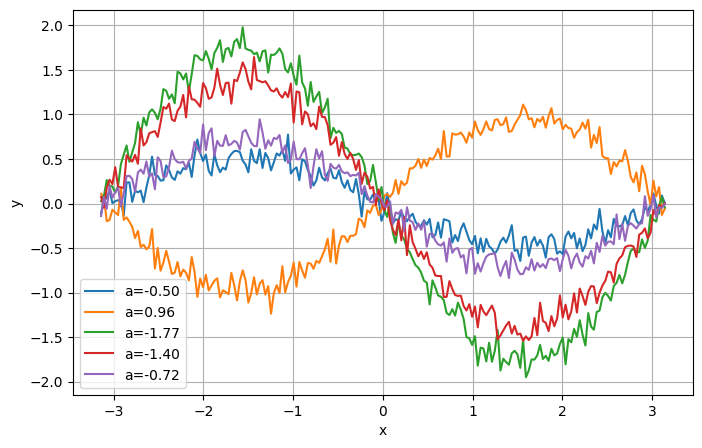

In [ ]:
#| echo: false
x = np.linspace(-np.pi, np.pi, 200)
plt.figure(figsize=(8, 5))

for i in range(5):
    a = np.random.uniform(-2, 2)
    y = sine(x, a) + np.random.normal(0, 0.1,size=x.shape)
    plt.plot(x, y, label=f"a={a:.2f}")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


### The Model

A CNP has two main components:

1. Encoder : A neural network that takes in context pair $(x_i , y_i)$ and transforms them into representation vector $r_i$. To combine information from all context points, we take an average over all points and get a vector $r$ of same dimension as each vector $r_i$.
2. Decoder: A neural network that uses the representation $r$ to make predictions at target point $x_t$. We pass in concatenated $[r,x_t]$ as the input and the output is the predicted mean and variance of $y_t$. We normalize the value of sigma to make sure it is positive.

In [5]:
class Encoder(nn.Module):
  def __init__(self, output_dim):
    super().__init__()
    self.fc1 = nn.Linear(2, 128) # (x_context, y_context) as input
    self.fc2 = nn.Linear(128, 128)
    self.fc3 = nn.Linear(128, output_dim)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

class Decoder(nn.Module):
  def __init__(self,r_dim):
    super().__init__()
    self.fc1 = nn.Linear(r_dim+1, 128) # (r vector, x_target) concatenated as input
    self.fc2 = nn.Linear(128, 2)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    mu,log_sigma = x.chunk(2, dim=-1)
    return mu, log_sigma

class ConditionalNeuralProcess(nn.Module):
  def __init__(self,r_dim):
    super().__init__()
    self.encoder = Encoder(r_dim)
    self.decoder = Decoder(r_dim)

  def forward(self,context_x,context_y,target_x):

    context_point = torch.cat([context_x, context_y], dim=-1)
    r_i = self.encoder(context_point)
    r =torch.mean(r_i,dim=0)
    num_target = target_x.shape[0]
    r_expanded = r.expand(num_target, -1)
    decoder_input = torch.cat([r_expanded, target_x], dim=-1)

    mu, log_sigma = self.decoder(decoder_input)
    sigma = torch.exp(log_sigma) # variance must be positive

    return mu, sigma

r_dim = 128
model = ConditionalNeuralProcess(r_dim).to(device)


The code below will help us visualize the model inputs and predictions.

In [6]:
def visualize_cnp_predictions(model, context_x, context_y, target_x, target_y):
    model.eval()

    with torch.no_grad():
        # Generate a dense range of x-values to plot the learned function smoothly
        x_plot = torch.linspace(-np.pi, np.pi, 500, device=device).unsqueeze(-1)


        mu_pred, sigma_pred = model(context_x, context_y, x_plot)

        context_x_np = context_x.cpu().numpy()
        context_y_np = context_y.cpu().numpy()
        target_x_np = target_x.cpu().numpy()
        target_y_np = target_y.cpu().numpy()
        x_plot_np = x_plot.cpu().numpy()
        mu_pred_np = mu_pred.cpu().numpy()
        sigma_pred_np = sigma_pred.cpu().numpy()

    plt.figure(figsize=(10, 6))

    plt.scatter(context_x_np, context_y_np, c='red', label='Context Points', marker='o', s=70)
    plt.scatter(target_x_np, target_y_np, c='blue', label='True Target Points', marker='x', s=70)

    plt.plot(x_plot_np, mu_pred_np, color='green', linewidth=2, label='Predicted Mean')
    plt.fill_between(
        x_plot_np.squeeze(),
        (mu_pred_np - 2 * sigma_pred_np).squeeze(),
        (mu_pred_np + 2 * sigma_pred_np).squeeze(),
        color='green', alpha=0.2, label='2σ Uncertainty'
    )

    plt.title('Conditional Neural Process Predictions')
    plt.xlabel('X', fontsize=12)
    plt.ylabel('Y', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()


Lets sample data for an example function with a = 2. What does our model's prediction look like before training? 

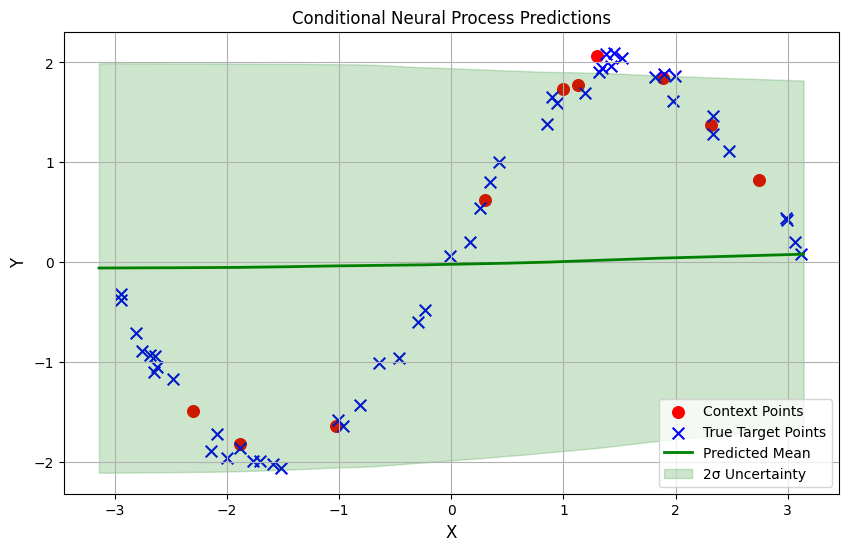

In [ ]:
#| echo: false
x_context_example, y_context_example, x_target_example, y_target_example = create_training_data(sine,a=2,num_points=60,num_context=10)
visualize_cnp_predictions(model,x_context_example,y_context_example,x_target_example,y_target_example)

### Training

The model is trained by minimizing the negative log-likelihood (NLL) — encouraging the predicted distributions to assign high probability to the true target values.

In [ ]:
r_dim = 128
model = ConditionalNeuralProcess(r_dim).to(device)

def NLL(mu_pred, sigma_pred, target_y):
    dist = Normal(mu_pred, sigma_pred)
    log_prob = dist.log_prob(target_y)
    loss = -torch.mean(log_prob)

    return loss

optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10000
losses=[]
predictions_example=[]
x_plot_example = torch.linspace(-np.pi, np.pi, 500, device=device).unsqueeze(-1)

for epoch in range(num_epochs):
    x_context, y_context, x_target, y_target = create_training_data(sine)
    optimizer.zero_grad()
    mu_pred, sigma_pred = model(x_context, y_context, x_target)
    loss = NLL(mu_pred, sigma_pred, y_target)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()

    if (epoch+1) % 1000 == 0:
      # visualize_cnp_predictions(model,x_context_example,y_context_example,x_target_example,y_target_example)
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    with torch.no_grad():
        mu, sigma = model(x_context_example, y_context_example, x_plot_example)
        predictions_example.append((mu.cpu().numpy(), sigma.cpu().numpy()))


Epoch 1000/10000, Loss: -0.39137786626815796
Epoch 2000/10000, Loss: 0.9421440958976746
Epoch 3000/10000, Loss: -0.3440188467502594
Epoch 4000/10000, Loss: -0.7226278781890869
Epoch 5000/10000, Loss: -0.3659144937992096
Epoch 6000/10000, Loss: -0.5449066162109375
Epoch 7000/10000, Loss: -0.2978738844394684
Epoch 8000/10000, Loss: -0.5170844197273254
Epoch 9000/10000, Loss: -0.5219289064407349
Epoch 10000/10000, Loss: -0.6298805475234985


The losses for the overall training process oscillate a lot but we can see a downward trend, as in the plot below.

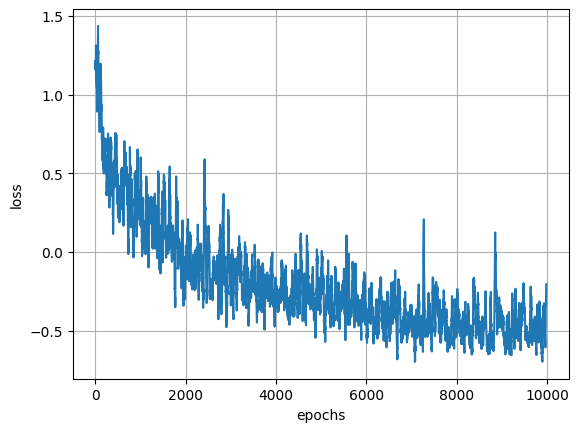

In [13]:
#| echo: false
window = 20
smooth_losses = np.convolve(losses, np.ones(window)/window, mode="valid")
plt.plot(smooth_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.show()

We can visualize how the training makes our model converge to the example function using a short animation. Observe how the shaded green area indicating variance becomes smaller as our model becomes more accurate and confident.

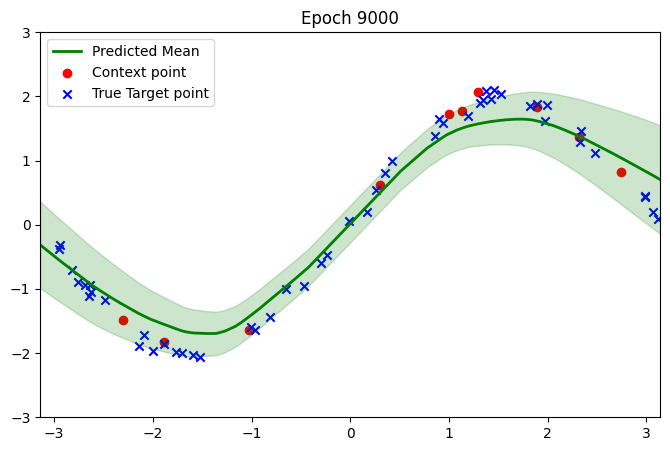

In [ ]:
#| include: false
fig, ax = plt.subplots(figsize=(8, 5))
line, = ax.plot([], [], 'g-', lw=2, label="Predicted Mean")
fill = None

ax.scatter(x_context_example.cpu(), y_context_example.cpu(),
           c='red', label="Context point")
ax.scatter(x_target_example.cpu(), y_target_example.cpu(),
           c='blue', marker='x', label="True Target point")
x_plot_example = np.linspace(-np.pi, np.pi, 500).reshape(-1, 1)

ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-3, 3)
ax.legend()

def init():
    return line,

def update(frame):
    global fill
    if fill: fill.remove()

    mu, sigma = predictions_example[frame]
    line.set_data(x_plot_example, mu)
    fill = ax.fill_between(
        x_plot_example.squeeze(),
        (mu - 2 * sigma).squeeze(),
        (mu + 2 * sigma).squeeze(),
        color='green', alpha=0.2
    )
    ax.set_title(f"Epoch {frame}")
    return line, fill

ani = animation.FuncAnimation(
    fig, update, range(0, len(predictions_example), 1000),
    init_func=init, blit=False, interval=200
)

ani.save("cnp_training.gif", writer="pillow", dpi=80)


![](cnp_training.gif){fig-align="center"}

### Conclusion

So, after training, the model is predicting a good approximation of our function.

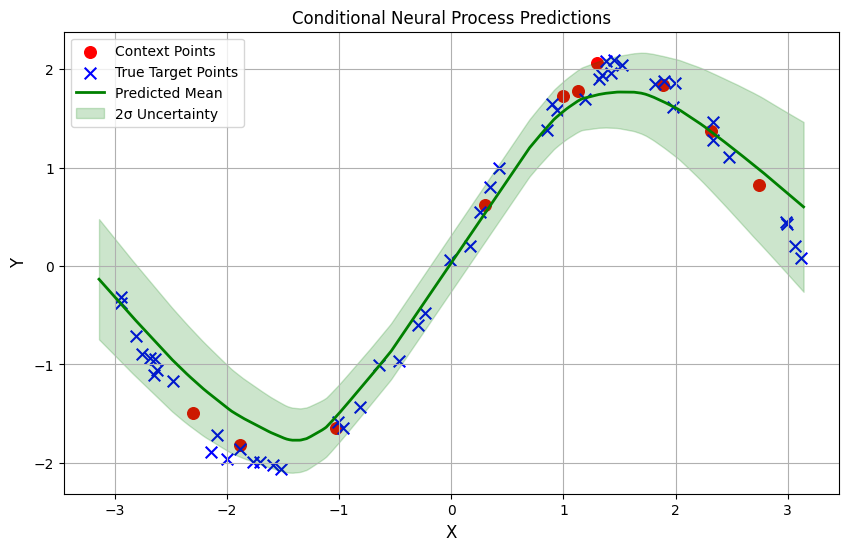

In [ ]:
#| echo: false
visualize_cnp_predictions(model,x_context_example,y_context_example,x_target_example,y_target_example)

I would say that CNPs are a rather simple approximation to neural processes. Their aggregator function being simply a mean may lose information and they do not model uncertainty as well, being a deterministic model. However they are simple to train and perform reasonably well on simple functions such as the sine wave.

Credits to [Kaspar Martens](https://kasparmartens.rbind.io/post/np/) and [Deepmind](https://colab.research.google.com/github/deepmind/neural-processes/blob/master/conditional_neural_process.ipynb#scrollTo=P3LJYP1Qh-jO)  for an excellent tutorial on this topic.